In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# df = pd.read_parquet('s29_training.parquet')
#df = pd.read_parquet('datavalidasi2_1cyc.parquet')
df = pd.read_parquet('datavalidasi3_1cyc.parquet')
df

Cell                    Time  Time (s)  dTime   Voltage   Current   
0         1 2018-09-17 11:17:37.170      0.00   0.00  4.043151  0.869627  \
1         1 2018-09-17 11:17:37.180      0.01   0.01  4.040241  0.765159   
2         1 2018-09-17 11:17:37.200      0.03   0.02  4.040241  0.765159   
3         1 2018-09-17 11:17:37.270      0.10   0.07  4.047878  1.061622   
4         1 2018-09-17 11:17:37.360      0.19   0.09  4.041696  0.804687   
...     ...                     ...       ...    ...       ...       ...   
39397     1 2018-09-17 13:03:44.250   6367.08   0.04  2.704957 -6.566317   
39398     1 2018-09-17 13:03:44.310   6367.14   0.06  2.710413 -6.319304   
39399     1 2018-09-17 13:03:44.330   6367.16   0.02  2.710413 -6.319304   
39400     1 2018-09-17 13:03:44.380   6367.21   0.05  2.707503 -6.432224   
39401     1 2018-09-17 13:03:44.500   6367.33   0.12  2.740965 -5.120937   

       Temperature  dCapacity_a  dCapacity_b  discharge capacity (Ah)   
0            26.25     0.000000     0.000000                 2.573356  \
1            26.25     0.000002     0.000002                 2.573356   
2            26.25     0.000004     0.000006                 2.573356   
3            26.25     0.000021     0.000027                 2.573356   
4            26.25     0.000020     0.000047                 2.573356   
...            ...          ...          ...                      ...   
39397        29.75     0.000073     2.572956                 2.572956   
39398        29.75     0.000105     2.573061                 2.573061   
39399        29.75     0.000035     2.573096                 2.573096   
39400        29.75     0.000089     2.573186                 2.573186   
39401        29.75     0.000171     2.573356                 2.573356   

       charge capacity (Ah)    deltaV        DOD      SOCref       OCV   
0                  2.573356  0.000000   0.000000  100.000000  4.005922  \
1                  2.573358  0.002909   0.000063  100.000063  4.007485   
2                  2.573363  0.000000   0.000188  100.000188  4.007485   
3                  2.573383  0.007637   0.000795  100.000795  4.002430   
4                  2.573403  0.006182   0.001386  100.001386  4.007247   
...                     ...       ...        ...         ...       ...   
39397              0.000000  0.059649  75.675169   24.324831  3.230328   
39398              0.000000  0.005456  75.678267   24.321733  3.216020   
39399              0.000000  0.000000  75.679300   24.320700  3.216020   
39400              0.000000  0.002910  75.681927   24.318073  3.222145   
39401              0.000000  0.033462  75.686948   24.313052  3.150691   

       dEnergy_a  dEnergy_b  discharge energy (Wh)  charge energy (Wh)  
0       0.000000   0.000000               8.891794            8.891794  
1       0.000009   0.000009               8.891794            8.891803  
2       0.000017   0.000026               8.891794            8.891820  
3       0.000084   0.000109               8.891794            8.891904  
4       0.000081   0.000191               8.891794            8.891985  
...          ...        ...                    ...                 ...  
39397   0.000197   8.890704               8.890704            0.000000  
39398   0.000285   8.890990               8.890990            0.000000  
39399   0.000095   8.891085               8.891085            0.000000  
39400   0.000242   8.891327               8.891327            0.000000  
39401   0.000468   8.891794               8.891794            0.000000  

[39402 rows x 19 columns]

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

#Menampilkan grafik
plt.figure(figsize = (16,10))

# load dataset
df = pd.read_parquet('datavalidasi3_1cyc.parquet')

# plot temperatur terhadap waktu pada setiap siklus
plt.scatter(df['SOCref'], df['Voltage'], s=10)

plt.xlabel('SOC (%)')
plt.ylabel('Tegangan (V)')
plt.title('Grafik OCV terhadap SOC')
plt.legend()
plt.grid(True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [10]:
# Energi yang bertambah tiap detik
df['dEnergy_a'] = (df['OCV']*df['Current']*df['dTime']/3600)

# Akumulasi energi bertambah pada waktu ke-n
df['dEnergy_b'] = df['dEnergy_a'][0]

for i in range(1, len(df)):
    df.loc[i, 'dEnergy_b'] = df.loc[i-1, 'dEnergy_b'] + df.loc[i, 'dEnergy_a']

# Discharge Energy
en_min = df['dEnergy_b'].min()

def calc_edc(row):
    if row['Current'] <= 0:
        return abs(row['dEnergy_b'])
    else:
        return en_min*(-1)

df['discharge energy (Wh)'] = df.apply(calc_edc, axis=1)

# Charge Energy
def calc_ecc(row):
    if row['Current'] >= 0:
        return (en_min*(-1))+row['dEnergy_b']
    else:
        return 0
df['charge energy (Wh)'] = df.apply(calc_ecc, axis=1)

In [7]:
# df.to_parquet('s29_training.parquet', index=False)
df.to_parquet('datavalidasi3_1cyc.parquet', index=False)

# Gabung Data

### Data Training

In [110]:
df = pd.concat(
    map(pd.read_parquet, ['s1_training.parquet', 's2_training.parquet', 's3_training.parquet', 's4_training.parquet', 's5_training.parquet', 's6_training.parquet', 's7_training.parquet', 's8_training.parquet', 's9_training.parquet', 's10_training.parquet', 's11_training.parquet', 's12_training.parquet', 's13_training.parquet', 's14_training.parquet', 's15_training.parquet', 's16_training.parquet', 's17_training.parquet', 's18_training.parquet', 's19_training.parquet', 's20_training.parquet']), ignore_index=True)
print(df)

        Cell                    Time  Time (s)  dTime   Voltage   Current   
0          1 2018-09-05 20:00:10.430      0.00   0.00  4.150365 -1.020517  \
1          1 2018-09-05 20:00:11.420      0.99   0.99  4.148910 -1.020517   
2          1 2018-09-05 20:00:12.400      1.97   0.98  4.147455 -1.020517   
3          1 2018-09-05 20:00:13.410      2.98   1.01  4.146000 -1.019106   
4          1 2018-09-05 20:00:14.400      3.97   0.99  4.145273 -1.021929   
...      ...                     ...       ...    ...       ...       ...   
546324    20 2018-09-06 03:15:40.160  25283.42   0.99  4.198270  0.220181   
546325    20 2018-09-06 03:15:41.180  25284.44   1.02  4.197906  0.220181   
546326    20 2018-09-06 03:15:42.170  25285.43   0.99  4.198270  0.220181   
546327    20 2018-09-06 03:15:43.180  25286.44   1.01  4.198270  0.220181   
546328    20 2018-09-06 03:15:44.160  25287.42   0.98  4.198270  0.220181   

        Temperature  dCapacity_a  dCapacity_b  discharge capacity (Ah)   
0

In [111]:
df.to_parquet('datatraining_20cyc.parquet', index=False)

In [112]:
df.describe()

Cell                           Time       Time (s)   
count  546329.000000                         546329  546329.000000  \
mean       10.499283  2018-09-05 23:37:22.344056064   12717.798622   
min         1.000000     2018-09-05 19:57:24.530000       0.000000   
25%         5.000000     2018-09-05 21:48:52.600000    6208.010000   
50%        11.000000     2018-09-05 23:41:36.200000   12988.690000   
75%        16.000000     2018-09-06 01:25:30.160000   19205.500000   
max        20.000000     2018-09-06 03:22:49.170000   25995.510000   
std         5.773271                            NaN    7425.743407   

               dTime        Voltage        Current    Temperature   
count  546329.000000  546329.000000  546329.000000  546329.000000  \
mean        0.926282       3.729458      -0.001205      26.760071   
min         0.000000       2.649477      -1.028899      25.687500   
25%         0.980000       3.521241      -1.019854      26.312500   
50%         1.000000       3.749063       0.256391      26.625000   
75%         1.010000       3.989285       1.019602      27.250000   
max        10.040000       4.200330       1.029312      28.562500   
std         0.368908       0.321386       0.994013       0.538743   

         dCapacity_a    dCapacity_b  discharge capacity (Ah)   
count  546329.000000  546329.000000            546329.000000  \
mean        0.000248       1.646659                 2.573284   
min         0.000000       0.000000                 0.000000   
25%         0.000272       0.763218                 1.758647   
50%         0.000281       1.643018                 3.366870   
75%         0.000286       2.522899                 3.390399   
max         0.000303       3.399993                 3.408424   
std         0.000073       1.010103                 1.085899   

       charge capacity (Ah)         deltaV            DOD         SOCref   
count         546329.000000  546329.000000  546329.000000  546329.000000  \
mean               0.926626       0.000274      48.431136      51.568864   
min                0.000000       0.000000       0.000000       0.000221   
25%                0.000000       0.000000      22.447589      25.797102   
50%                0.101737       0.000364      48.324055      51.675945   
75%                1.862888       0.000366      74.202898      77.552411   
max                3.408399       0.093353      99.999779     100.000000   
std                1.164191       0.000595      29.708918      29.708918   

                 OCV      dEnergy_a      dEnergy_b  discharge energy (Wh)   
count  546329.000000  546329.000000  546329.000000          546329.000000  \
mean        3.746706       0.000007      -6.319957               9.678839   
min         2.649477      -0.001256     -12.656709               0.000000   
25%         3.545284      -0.001025      -9.661557               6.954217   
50%         3.764644       0.000123      -6.448627              12.426512   
75%         4.007193       0.001024      -3.032145              12.569826   
max         4.250562       0.001246       0.286668              12.656709   
std         0.309275       0.000968       3.807628               3.916406   

       charge energy (Wh)  
count       546329.000000  
mean             3.358882  
min              0.000000  
25%              0.000000  
50%              0.313782  
75%              6.623419  
max             12.816565  
std              4.301585

### Data Validasi

In [113]:
df = pd.concat(
    map(pd.read_parquet, ['s22_training.parquet', 's23_training.parquet', 's24_training.parquet', 's25_training.parquet', 's26_training.parquet', 's27_training.parquet', 's28_training.parquet', 's29_training.parquet']), ignore_index=True)
print(df)

        Cell                    Time  Time (s)  dTime   Voltage   Current   
0         22 2019-03-21 21:58:07.150      0.00   0.00  4.150365 -1.020517  \
1         22 2019-03-21 21:58:07.960      0.81   0.81  4.148546 -1.020517   
2         22 2019-03-21 21:58:08.150      1.00   0.19  4.148183 -1.020517   
3         22 2019-03-21 21:58:09.160      2.01   1.01  4.147092 -1.020517   
4         22 2019-03-21 21:58:10.160      3.01   1.00  4.146000 -1.020517   
...      ...                     ...       ...    ...       ...       ...   
216396    29 2019-04-18 03:48:53.940  24812.07   0.15  4.197514  0.119286   
216397    29 2019-04-18 03:48:54.940  24813.07   1.00  4.197514  0.119286   
216398    29 2019-04-18 03:48:55.930  24814.06   0.99  4.197149  0.119286   
216399    29 2019-04-18 03:48:56.950  24815.08   1.02  4.197514  0.117866   
216400    29 2019-04-18 03:48:57.940  24816.07   0.99  4.197879  0.117866   

        Temperature  dCapacity_a  dCapacity_b  discharge capacity (Ah)   
0

In [114]:
df.to_parquet('datavalidasi_8cyc.parquet', index=False)

In [115]:
df.describe()

Cell                           Time       Time (s)   
count  216401.000000                         216401  216401.000000  \
mean       25.495640  2019-03-28 19:33:27.656569856   12613.358751   
min        22.000000     2019-03-21 21:58:07.150000       0.000000   
25%        23.000000     2019-03-22 00:15:47.120000    6165.030000   
50%        26.000000     2019-03-22 02:41:57.360000   12869.930000   
75%        28.000000     2019-04-17 20:56:59.900000   19039.780000   
max        29.000000     2019-04-18 04:08:17.490000   25683.000000   
std         2.294458                            NaN    7359.373052   

               dTime        Voltage        Current    Temperature   
count  216401.000000  216401.000000  216401.000000  216401.000000  \
mean        0.931712       3.730253      -0.000312      26.362913   
min         0.000000       2.649672      -1.028274      25.687500   
25%         0.980000       3.522360      -1.019854      26.125000   
50%         1.000000       3.751219       0.261170      26.312500   
75%         1.010000       3.989329       1.019713      26.500000   
max        10.030000       4.200330       1.029162      27.375000   
std         0.417534       0.322029       0.993615       0.344338   

         dCapacity_a    dCapacity_b  discharge capacity (Ah)   
count  216401.000000  216401.000000            216401.000000  \
mean        0.000248       1.633268                 2.551964   
min         0.000000       0.000000                 0.000000   
25%         0.000277       0.755911                 1.746634   
50%         0.000282       1.629479                 3.302872   
75%         0.000286       2.503408                 3.368166   
max         0.000300       3.382919                 3.382919   
std         0.000072       1.003028                 1.075770   

       charge capacity (Ah)         deltaV            DOD         SOCref   
count         216401.000000  216401.000000  216401.000000  216401.000000  \
mean               0.918696       0.000272      48.037283      51.962717   
min                0.000000       0.000000       0.000000       0.502395   
25%                0.000000       0.000000      22.232691      26.370358   
50%                0.099121       0.000364      47.925863      52.074137   
75%                1.847102       0.000366      73.629642      77.767309   
max                3.382913       0.095181      99.497605     100.000000   
std                1.154744       0.000649      29.500815      29.500815   

                 OCV      dEnergy_a      dEnergy_b  discharge energy (Wh)   
count  216401.000000  216401.000000  216401.000000          216401.000000  \
mean        3.745734       0.000008      -6.258823               9.593495   
min         2.649672      -0.001248     -12.520335               0.000000   
25%         3.544233      -0.001027      -9.577223               6.900570   
50%         3.765160       0.000204      -6.386322              12.284565   
75%         4.006983       0.001025      -2.994030              12.444107   
max         4.246741       0.001230       0.309346              12.520335   
std         0.310109       0.000968       3.780894               3.878744   

       charge energy (Wh)  
count       216401.000000  
mean             3.334672  
min              0.000000  
25%              0.000000  
50%              0.309207  
75%              6.576529  
max             12.753453  
std              4.271207

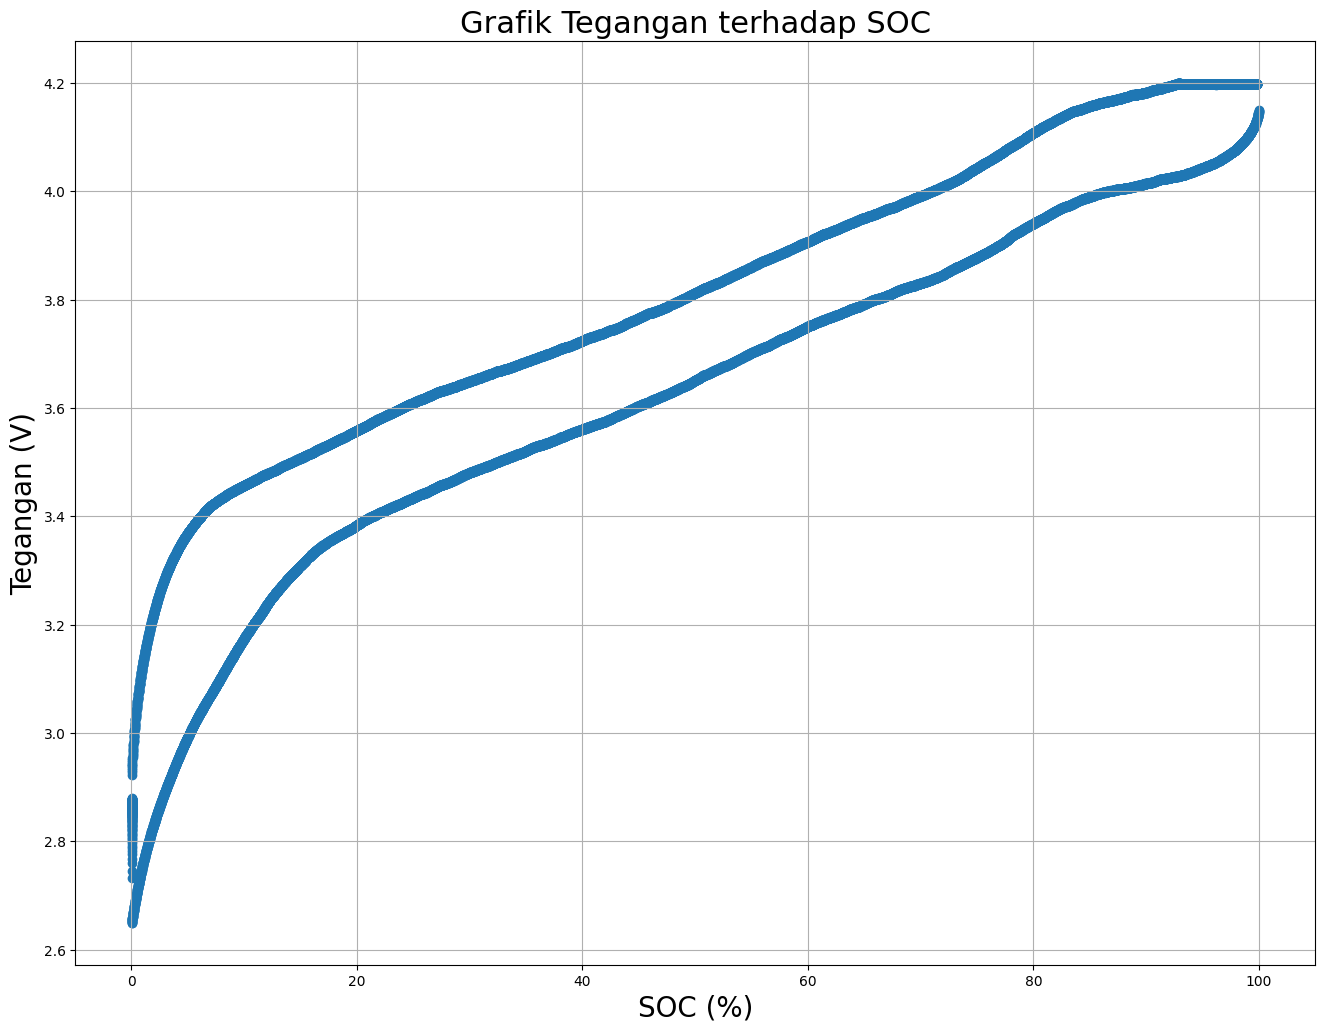

In [117]:
import matplotlib.pyplot as plt
import pandas as pd

#Menampilkan grafik
plt.figure(figsize = (16,12))

# load dataset
df = pd.read_parquet('s1_training.parquet')

# plot temperatur terhadap waktu pada setiap siklus
plt.scatter(df['SOCref'], df['Voltage'])

plt.xlabel('SOC (%)', fontsize=20)
plt.ylabel('Tegangan (V)', fontsize=20)
plt.title('Grafik Tegangan terhadap SOC', fontsize=22)
#plt.legend()
plt.grid(True)